In [24]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [25]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    10: ['c_custkey', 'c_name', 'c_acctbal', 'c_phone', 'n_name', 'c_address', 'c_comment'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]

In [26]:
q4_dp = {'1-URGENT': [1.9094966190370435,
  1.4390167527426396,
  0.9905998292811071,
  0.6914595858610769,
  0.46419855560261797,
  0.31079773045000797,
  0.17593472263054316,
  0.04416950355088001,
  0.04375585811854141,
  0.042652271600614695],
 '2-HIGH': [2.0380113214257403,
  1.4006948453598298,
  1.0362043387791677,
  0.6815240241527991,
  0.46012590791650193,
  0.31987457214214776,
  0.16049147051813964,
  0.04476538026303727,
  0.04502451991323763,
  0.04347198844732975],
 '3-MEDIUM': [2.015067079989976,
  1.3656586075759645,
  0.985136793056168,
  0.6680317514185643,
  0.44201784625012314,
  0.29375011856122263,
  0.16316300840274026,
  0.0427369536474568,
  0.041347286714669786,
  0.040849264576639496],
 '4-NOT SPECIFIED': [2.0639185449041406,
  1.384206214467273,
  1.064612070607331,
  0.6884686281536756,
  0.4840810775535314,
  0.3230233935064605,
  0.1731452507848902,
  0.04499361879423069,
  0.041972392832094134,
  0.04308354963735532],
 '5-LOW': [1.7801016596146355,
  1.2906843551266087,
  0.894379340448067,
  0.6804902222560051,
  0.43711682319118156,
  0.28034385440181425,
  0.16442136400801968,
  0.039964944871300236,
  0.04219007226291092,
  0.0374625929465158]}

In [27]:
def graph_query1(full_df):
    print("Q1")
    q1_dict = {'pct_diff_avg_qty': "Average Quantity",
     'pct_diff_avg_price': "Average Price",
     'pct_diff_sum_disc_price': "Sum of Discounted Price",
     'pct_diff_sum_qty': "Sum of Quantity of Lineitems",
     'pct_diff_sum_base_price': "Sum of Base Price",
     'pct_diff_avg_disc': "Average Discount",
     'pct_diff_count_order': "Count of Lineitems",
     'pct_diff_sum_charge': "Sum of Total Price "}
    # Create 4x2 subplot grid
    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)

    pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]
    returnflag = full_df['l_returnflag'].unique().sort()
    linestatus = full_df['l_linestatus'].unique().sort()

    # First pass: collect all y-data for each row to determine shared y-limits
    row_y_data = {row: [] for row in range(4)}

    for i, col in enumerate(pct_diff_cols):
        row = i // 2

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                y = group_data[col]
                if len(y.to_list()) > 0:
                    row_y_data[row].extend(y.to_list())

    # Calculate y-limits for each row
    row_y_limits = {}
    for row in range(4):
        if row_y_data[row]:
            y_min = min(row_y_data[row])
            y_max = max(row_y_data[row])
            # Add some padding
            y_range = y_max - y_min
            padding = y_range * 0.05
            row_y_limits[row] = (y_min - padding, y_max + padding)
        else:
            row_y_limits[row] = (0, 1)  # default range

    # Second pass: create the plots
    for i, col in enumerate(pct_diff_cols):
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                xs = [np.log2(x) for x in group_data['mi']]
                y = group_data[col]
                print(flag, status, y.to_list())
                if len(y.to_list()) > 0:
                    ax.plot(xs, y.to_list(),linestyle='dotted',
                        label=f'Return Flag: {flag}, Status: {status}', 
                        markersize=10, mew=1.5)

        # Set shared y-limits for this row
        ax.set_ylim(row_y_limits[row])

        # X-axis label for bottom row only
        if row == 3:  # bottom row
            ax.set_xlabel('Mutual Information (log scale)', fontsize=14)

        # Y-axis label only for left column
        if col_idx == 0:  # left column
            ax.set_ylabel('Relative Error (%)', fontsize=14)

        ax.set_title(f'Approximating {q1_dict[col]}', fontsize=16)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../figs/q1_results.png')

In [28]:
def graph_query14(full_df):
    print("Q14!")
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    xs = [np.log2(x) for x in full_df['mi']]
    y = full_df['pct_diff_promo_revenue']
    print(y.to_list())
    ax.plot(xs, y.to_list(), linestyle='dotted', markersize=10, mew=1.5)

    ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
    ax.set_ylabel(f'Relative Error (%)', fontsize=14)
    ax.set_title(f'Approximating Promo Revenue Percentage', fontsize=16)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../figs/q14_results.png')

In [29]:
def graph_query4(full_df):
    print("Q4!")
    fig, axes = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
    priorities = full_df['o_orderpriority'].unique().sort()
    labels = ["PAC", "DP"]
    for i in range(len(labels)):
        ax = axes[i]
        xs = [np.log2(x) for x in full_df['mi'].unique().sort().to_list()]
        if i == 0:
            print("PAC")
            for priority in priorities:
                group_data = full_df.filter(pl.col('o_orderpriority') == priority).sort('mi')
                
                y = group_data['pct_diff_order_count']
                ax.plot(xs, y.to_list(), linestyle='dotted',
                    label=f'Priority: {priority}', markersize=10, mew=1.5
                )
                print(priority, y.to_list())
        if i == 1:
            print("DP")
            for priority in priorities:
                ys = q4_dp[priority]
                print(priority, ys)
                ax.plot(xs, ys, linestyle='dotted', label=f'Priority: {priority}', markersize=10, mew=1.5)

        ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
        ax.set_ylabel(f'Relative Error (%)', fontsize=14)
        ax.set_title(f'Approximating Order Count Difference Percentage ({labels[i]})', fontsize=16)
        ax.legend()
        ax.grid(True, alpha=0.3)
#     plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)  # hspace controls vertical spacing
    plt.savefig('../figs/q4_results.png', bbox_inches='tight')

In [30]:
def graph_query12(full_df):
    print("Q12")
    fig, axes = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
    for ind, key in enumerate(['pct_diff_high_line_count', 'pct_diff_low_line_count']):
        names = ["High", "Low"]
        ax = axes[ind]

        priorities = full_df['l_shipmode'].unique().sort()

        for priority in priorities:
            group_data = full_df.filter(pl.col('l_shipmode') == priority).sort('mi')
            xs = [np.log2(x) for x in group_data['mi']]
            y = group_data[f'pct_diff_{names[ind].lower()}_line_count']
            ax.plot(xs, y.to_list(),linestyle='dotted', markersize=10, mew=1.5,
                label=f'Ship Mode: {priority}'
            )
            print('priority')
            print(y.to_list())

        ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
        ax.set_ylabel(f'Relative Error (%)', fontsize=14)
        ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=16)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('../figs/q12_results.png')

In [31]:
def graph_query(full_df, query_ind):
    if query_ind == 1:
        graph_query1(full_df)
    if query_ind == 14:
        graph_query14(full_df)
    if query_ind == 4:
        graph_query4(full_df)
    if query_ind == 12:
        graph_query12(full_df)

Q12
priority
[21.557610898480807, 15.300471288832036, 10.993529009519465, 8.067019611760884, 6.342790490021463, 5.693050365963216, 4.754058772924424, 4.24431953391308, 4.112668566922086, 3.9607590471892]
priority
[19.875466990264794, 14.427060741289802, 10.332763092401837, 7.423859594048017, 5.776594247318527, 4.415437918227312, 3.8018020339611285, 3.4623616435710387, 3.189860746262568, 3.12996905611813]
priority
[11.100519714094942, 7.90429349443414, 5.586749036725221, 4.11115331854832, 3.005237959728769, 2.5907811709408017, 2.1344353850229982, 1.9301704207924655, 1.8027364488366704, 1.8248371931611282]
priority
[29.54539156507353, 21.01018614148308, 15.276056755672418, 10.869078536563418, 8.022298281239395, 6.431260933465357, 5.423611093042438, 4.922755616000057, 4.428636752140452, 4.527105329506118]


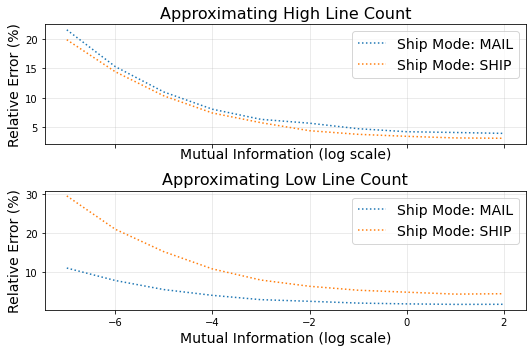

In [32]:
for query_ind in [12]:
    full_df = pl.DataFrame()
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        if query_ind == 10:
            orig = orig.select(
                pl.col("c_custkey"), pl.col("c_name"),
                pl.col("c_acctbal").cast(str),
                pl.col("n_name"), pl.col("c_address"), pl.col("c_phone"), pl.col("c_comment")
            )
        noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    new = np.average(
                        [100*abs(
                            const*merged_df[noised][ind][tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(merged_df[noised][ind]))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
        full_df = pl.concat([full_df, merged_df])
    graph_query(full_df, query_ind)

In [22]:
noised = full_df[0]['avg_yearly_noised'].to_list()[0] 
true = 23512.752857	
print(np.average([100*abs(2*k - true) / true for k in noised]))

101.54703458677366


In [200]:
avg_errors = {
    "Q2": 0.,
    "Q5": 25.622938327248313,
    "Q6": 3.975880395383505,
    "Q7": 26.254870522345144,
    "Q8": 120.43882910564585,
    "Q9": 23.271514480779384,
    "Q11": 0.,
    "Q13": 19.722793014350138,
    "Q15": 41.89916745531556,
    "Q16": 0.,
    "Q17": 39.95207812726525,
    "Q19": 85.3515578953771,
    "Q21": 68.63134006957296,
    "Q22": 25.083121818619354}

avg_errors_128 = {'Q2': 0,
 'Q5': 26.31282859954568,
 'Q6': 3.62221516091224,
 'Q7': 27.965866456515275,
 'Q8': 120.73795106807214,
 'Q9': 23.12962834929074,
 'Q11': 0,
 'Q13': 21.18177349111936,
 'Q15': 42.12171544059936,
 'Q17': 43.68733979981672,
 'Q19': 90.44930489664169,
 'Q21': 72.36672908827971,
 'Q22': 25.36833165645609}

null_pct = {
    "Q3": 100,
    "Q13": 13.513513513513514,
    "Q10": 100,
    "Q18": 100,
    "Q21": 51.06382978723404,
}

null_pct_128 = {
    "Q3": 100,
    "Q13": 10.81081081081081,
    "Q10": 100,
    "Q18": 100,
    "Q21": 25.53191489361702
}

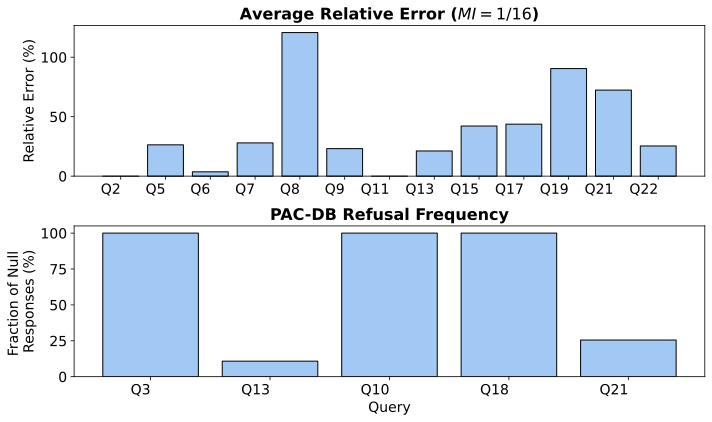

In [201]:
# Create the bar plot for unnoised times
import matplotlib as mpl
import matplotlib_inline.backend_inline

mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

error_keys = avg_errors_128.keys()
error_vals = avg_errors_128.values()
ax1.bar(error_keys, error_vals, color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax1.set_xticks(x, error_keys, ha='right', fontsize=14)
# ax1.set_xlabel('Query', fontsize=16)
ax1.set_ylabel('Relative Error (%)', fontsize=14)
ax1.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax1.set_title("Average Relative Error ($MI = 1/16$)", fontsize=16)


error_keys = null_pct_128.keys()
error_vals = null_pct_128.values()
ax2.bar(error_keys, error_vals,color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax2.set_xticks(x, error_keys, ha='right', fontsize=14)
ax2.set_xlabel('Query', fontsize=14)
ax2.set_ylabel('Fraction of Null \nResponses (%)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax2.set_title("PAC-DB Refusal Frequency", fontsize=16)

plt.subplots_adjust(hspace=0.5)  # Add padding between plots
plt.tight_layout()
plt.savefig('figs/overall_utility.png')